# Charon4 txt to Python
This script loads the data exported with charon4. The following screenshot shows the expected settings while exporting.

2018 data are exported processed different, see `charon4_txt_to_python_2018data.ipynb`

<img src=".\pictures\Charon4_export_window_txt.png" alt="drawing" width="500"/>

The results of this script are stored in `..\Alsdorf\Daten\my_database`. The goal of this database is to contain all data in an easy to read format.

At the moment this script always loads and saves all data, it does not check which data already is in the existing database. I did not plan yet to implement that

In [1]:
version="v1_4"
# Changelog
#v1_0: has a nice overviwe at the end
#v1_1: add temp data from daniel to data_2019; length are int now; added seperate import for 2018
#v1_2: seperated this notebook into different ones; outsourced some user-defined functions
#v1_3: added import for multiple controller files; removed_data_for_month_avaible variable and plot, removed a bug in merging daniel data in 2019
#v1_4:

#???????????Charon4 does not export the last two hours, as selected? But exports 2 hours more at the beginning? 
# Time Zone recalculation within the software?
# --> irgendwann nochmal genauer checken
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date, timedelta
from collections import defaultdict
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
import pickle

# import my User defined functions
from my_func_mvw.functions import get_abspath, all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday

In [12]:
# Input
#path to working directory
#mit \[-]\ im Pfad funktioniert die get_abspath Funktion nicht
# add additional paths to list, if you exported new data from Charon4
# if you have a lot of different paths to controller files, consider exporting the whole databse from Charon4 again
# this would increase the speed of this script (having less paths to controllers)
# but the export from Charon4 takes some time
path_to_controller=[r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt", r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt\07062021", r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt\08062021"]

#gleiches Verzeichnis auswählen in Charon4 klappt nicht, dann werden alle Sachen nochmal in den selben file am Ende dazu geschrieben

data_save_csv=False # True False; data saving takes about 9 min.
data_save_pickle=True #True False
plot_save=False # True False


In [3]:
#############Input###################################
# I think the inputs dont work. Using all is the best way at the moment
channels=[1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8]
years=[2019,2020,2021] #[2019,2020,2021] # 2018 is imported seperate from another data format
months=[1,2,3,4,5,6,7,8,9,10,11,12] #[1,2,3,4,5,6,7,8,9,10,11,12]
################################################

controller=3188 # 3188: Alsdorf

# generate all requested paths, some paths may be empty
# see here why defaultdict is used:
# https://stackoverflow.com/questions/44992106/how-do-i-create-a-nested-dictionary-under-a-key-that-is-yet-to-exist
paths_for_activate=defaultdict(dict)
for path_controller in path_to_controller:
    for year in years:
        for channel in channels:
            for month in months:
                paths_for_activate[path_controller][f"temp_ch{channel}_year{year}_month{month}"] = path_controller + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate

#Idee
# für jeden controller path seperate dic erstellen und alles einladen
# dic danach mergen
# darauf achten, dass doppelte Messungen am ende nicht auftauchen

In [4]:
def import_temp_to_df(path):
    """"""
    #print(path)
    # error_bad_lines, needed for data of 2018, where the length of the cable changes
    # the data is loast at the moment, by adding columns / changing the data file the data could be imported
    # I think this data wont be important anyway
    df = pd.read_csv(path,skiprows=7,decimal=".",delimiter="\t",index_col=0,error_bad_lines=False,warn_bad_lines=False)
    df = df.drop(df.columns[0:2],axis=1)
    df.index.names = ['Date']
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df.rename(columns=lambda x: int(float(x)), inplace=True)
    df.columns.names=["Length [m]"]
    return df

In [5]:
# Import Data

# maybe its best to store not everything in one variable, not sure if thats True. 

def import_path_for_activate(paths_for_activate):
    """imports all files listed in one path_for_activate dic
    paths to empty repositories are not used
    """

    data_2019=defaultdict(dict)
    data_2020=defaultdict(dict)
    data_2021=defaultdict(dict)

    for name in paths_for_activate.keys(): # loop for every channel of every month
        my_path=paths_for_activate[name] + "\*"
        my_path_to_file=get_abspath(my_path)

        # get info about data from name
        partition1=name.partition("_year")[-1].partition("_month")
        year=partition1[0]
        month=partition1[-1]
        channelnumber=name.partition("_year")[0].partition("temp_ch")[-1]

        # check if the month folder contains more than one file 
        if len(my_path_to_file) > 1:
            if name != "temp_ch2_year2019_month7":
                print("one months contains more than one file, script should be checked! Only encountered this ones")
                print(name)
            # adaption of script
            # Import Data, one option
            one_file=import_temp_to_df(my_path_to_file[0])
            for i in range(1,len(my_path_to_file)):
                additional_files=import_temp_to_df(my_path_to_file[i])
                #display(additional_files)
                #display(one_file)
                one_file=pd.concat([one_file,additional_files],axis=0)
                #display(one_file)
            
            ## Store Data in dic - best would be putting this in a user-defined-function
            # or creating an if with >=1
            
            if year == "2019":
                data_2019[channelnumber][month] = one_file

            if year == "2020":
                data_2020[channelnumber][month] = one_file

            if year == "2021":
                data_2021[channelnumber][month] = one_file
        
        #if len(my_path_to_file) == 0: # wenn pfad zu keinem file führt dann wird leere Liste returned
        
        if len(my_path_to_file) == 1:
            
            # Import Data, second option
            one_file=import_temp_to_df(my_path_to_file[0])

            ## Store Data in dic
            
            if year == "2019":
                data_2019[channelnumber][month] = one_file

            if year == "2020":
                data_2020[channelnumber][month] = one_file

            if year == "2021":
                data_2021[channelnumber][month] = one_file

    return data_2019, data_2020, data_2021



In [6]:
%%time
#Wall time: 1min 32s
# Import data

n_controller_files=len(path_to_controller)
data_2019_parts=[]
data_2020_parts=[]
data_2021_parts=[]
counter=0
for path in path_to_controller:
    data_2019_part, data_2020_part, data_2021_part = import_path_for_activate(paths_for_activate[path])

    data_2019_parts.append(data_2019_part)
    data_2020_parts.append(data_2020_part)
    data_2021_parts.append(data_2021_part)

    counter+=1



Wall time: 1min 49s


In [7]:
def merge_dics_data(data_A, data_B):
    """merges two different data dics of the same year"""
    # dic mergen, wenn key nicht vorhanden neuen hinzufügen
    # wenn key schon vorhanden, zu dataframe hinzufügen, aber prüfen ob eintrag schon existiert

    data_new=defaultdict(dict)

    for channel in channels:
        c=str(channel)

        # if channel is not avaible in one dic but in the other take the data from the dic
        if c not in data_A.keys() and c in data_B.keys():
            data_new[c]=data_B[c]

        elif c not in data_B.keys() and c in data_A.keys():
            data_new[c]=data_A[c]

        # if channel is in both look at months
        elif c in data_B.keys() and c in data_A.keys():
            for month in months:
                m=str(month)

                # if month is not avaible in one dic but in the other take the data from the dic
                if m not in data_A[c].keys() and m in data_B[c].keys():
                    data_new[c][m]=data_B[c][m]

                elif m not in data_B[c].keys() and m in data_A[c].keys():
                    data_new[c][m]=data_A[c][m]
                
                #if month is in both check if dataframes are equal
                elif m in data_B[c].keys() and m in data_A[c].keys():
                    
                    # if both have same index, theay are equal. So I can take one of them
                    # kann ich eigentlich weglassen und immer concaten und drop duplicate machen
                    # so ist aber schneller
                    if len(data_B[c][m].index) == len(data_A[c][m].index):
                        if data_B[c][m].index == data_A[c][m].index: #if len are not eyqual this gives an error
                            data_new[c][m] = data_A[c][m]
                        
                        else: #copy of other else
                            #concat dataframes, drop duplicetes and sort
                            data_new[c][m] = pd.concat([data_A[c][m],data_B[c][m]],axis=0).drop_duplicates()
                            data_new[c][m].sort_index(axis=0,inplace=True)
                            print(f"concat for channel {c}, month {m} (other else)")

                    # else they dont have the same index, one contains more / additional data
                    else:
                        #concat dataframes, drop duplicetes and sort
                        data_new[c][m] = pd.concat([data_A[c][m],data_B[c][m]],axis=0).drop_duplicates()
                        data_new[c][m].sort_index(axis=0,inplace=True)
                        print(f"concat for channel {c}, month {m}")

    return data_new


In [8]:
%%time
#Wall time: 2.94 s
# Merge different dics, which were exported seperate from Charon4
#print("2021")
#data_2021 = merge_dics_data(data_2021_parts[0], data_2021_parts[1])
#print("2020")
#data_2020 = merge_dics_data(data_2020_parts[0], data_2020_parts[1])
#print("2019")
#data_2019 = merge_dics_data(data_2019_parts[0], data_2019_parts[1])

def merge_parts(data_20xx_parts):
    """merges all the different parts"""

    data_20xx = data_20xx_parts[0] #final dataframe
    for i in range(1,len(data_20xx_parts)):
        data_20xx = merge_dics_data(data_20xx, data_20xx_parts[i])

    return data_20xx

print("2021")
data_2021 = merge_parts(data_2021_parts)
print("2020")
data_2020 = merge_parts(data_2020_parts)
print("2019")
data_2019 = merge_parts(data_2019_parts)

# does this work as expected?

2021
concat for channel 1, month 5
concat for channel 2, month 5
concat for channel 3, month 5
concat for channel 4, month 5
concat for channel 1, month 6
concat for channel 2, month 6
concat for channel 3, month 6
concat for channel 4, month 6
concat for channel 5, month 6
concat for channel 6, month 6
concat for channel 7, month 6
concat for channel 8, month 6
2020
2019
Wall time: 7.87 s


In [9]:
%%time
#Wall time: 41.3 s
# Import data from daniel
def import_data_Daniel(path):
    """import for data from sciebo Eduardschacht repository
    copied from compare script
    """
    df = pd.read_csv(path,delimiter = ',',index_col=0, header=7 )
    df = df.drop(df.columns[[0,1]], axis=1)
    df.index=pd.to_datetime(df.index, dayfirst = True).tz_localize(None)
    df.index=df.index.astype(str) # same column format as other dataframe
    df=df.transpose() # for having the same format as the other dataframe
    df.index=df.index.astype(float) #make depth to int
    df.index=df.index.astype(int) #make depth to int
    df.index.names = ['Depth [m]']
    df.columns.names=["Length [m]"] # was wollte ich hier machen?
    return df

def put_files_in_dataframe(list_of_paths,import_function):
    """
    merges files in one dataframe using an import_function (user-defined-functiom) in a list_of paths (list)
    copied from compare script --> not updated in comare script!!!
    """
    # Import Data
    dic={}
    for path in list_of_paths:
        dic[path]=import_function(path)

    # Merge files into one dataframe
    dic_concat=pd.concat(dic.values(),axis=1)
    dic_concat.columns = pd.to_datetime(dic_concat.columns)
    dic_concat = dic_concat.sort_index(axis=1)

    return dic_concat

# Import files
paths_to_working_dir=r"..\Alsdorf\Daten"
daniel_ch1_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch1\*")
daniel_ch2_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch2\*")
daniel_ch3_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch3\*")
daniel_ch4_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch4\*")
# Merge them in one dataframe
daniel_ch1=put_files_in_dataframe(daniel_ch1_paths,import_data_Daniel)
daniel_ch2=put_files_in_dataframe(daniel_ch2_paths,import_data_Daniel)
daniel_ch3=put_files_in_dataframe(daniel_ch3_paths,import_data_Daniel)
daniel_ch4=put_files_in_dataframe(daniel_ch4_paths,import_data_Daniel)

Wall time: 29 s


In [10]:
# Add daniel data to data_2019

def add_daniel_data_to_2019(daniel_chx,channel_of_daniel):
    """
    beide Datensätze sind gleich in dem Bereich wo sie sich überschneiden, siehe compare script

    daniel data will overwrite data in data_2019    
    """
    # Change the format of daniel data, so that it fits to data_2019
    daniel_chx.index.names=[""]
    daniel_chx=daniel_chx.transpose() #----geändert vorher ch2 - war bug!
    daniel_chx.index.names=["Date"]
    #daniel_chx.index=pd.to_datetime(daniel_chx.index) #now in put_files_in_dataframe()

    # Group data by month and create seperate dataframes
    # groupby your key / level and freq
    g = daniel_chx.groupby(pd.Grouper(level='Date', freq='M'))
    # groups to a list of dataframes with list comprehension
    dfs = [group for _,group in g]

    # Add the seperate dataframes from group in a dictionary, so they have the same format as data_2019
    daniel_dic=defaultdict(dict)
    count_month=3 # first month of daniel data, which will used as an overwrite
    for dataframe in dfs[1:]: #skip first one, so count_month fits--------------geändert - war bug!
        daniel_dic[channel_of_daniel][str(count_month)]=dataframe
        count_month+=1
        
    # Add data to 2019 dataframe
    for month in daniel_dic[channel_of_daniel].keys():
        data_2019[channel_of_daniel][month]=daniel_dic[channel_of_daniel][month]
    return daniel_dic
#Add the data
daniel_dic_1=add_daniel_data_to_2019(daniel_ch1,"1")
daniel_dic_2=add_daniel_data_to_2019(daniel_ch2,"2")
daniel_dic_3=add_daniel_data_to_2019(daniel_ch3,"3")
daniel_dic_4=add_daniel_data_to_2019(daniel_ch4,"4")

In [15]:
%%time
# Wall time: 12min 25s only csv
# Wall time: 24.4 s only pickle

def save_data_csv(data_20xx,save_to_path):
    """"""
    for channel in data_20xx.keys():
        # join all month, so that the data is saved
        first_month=list(data_20xx[channel].keys())[0]
        one_file=data_20xx[channel][first_month]
        for month in list(data_20xx[channel].keys())[1:]: #skip first month, defined above
            one_file=pd.concat([one_file, data_20xx[channel][month]], axis=0)
        
        # save data
        year=one_file.index[10].strftime("%Y") #randomly chose 10; very bad solution
        filename=f"\\temp_ch{channel}_{year}.csv"
        one_file.columns.names=["Length [m]"]
        one_file.to_csv(save_to_path + filename)

def write_pickle(save_to:str,data_20xx):
    #Function to write pickle Files
    for channel in data_20xx.keys():
        # join all month, so that the data is saved
        first_month=list(data_20xx[channel].keys())[0]
        one_file=data_20xx[channel][first_month]
        for month in list(data_20xx[channel].keys())[1:]: #skip first month, defined above
            one_file=pd.concat([one_file, data_20xx[channel][month]], axis=0)

        year=one_file.index[10].strftime("%Y") #randomly chose 10; very bad solution
        filename=f"\\temp_ch{channel}_{year}"
        with open(save_to + filename, 'wb') as handle:
            pickle.dump(one_file, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Which dataformat is best, thats nice short overview:
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# Save data
save_to = path_to_controller[0] + "\..\..\my_database"
if data_save_csv:
    save_data_csv(data_2021,save_to)
    save_data_csv(data_2020,save_to)
    save_data_csv(data_2019,save_to)
if data_save_pickle:
    save_to_pickle = path_to_controller[0] + "\..\..\my_database\pickle"
    write_pickle(save_to_pickle, data_2021)
    write_pickle(save_to_pickle, data_2020)
    write_pickle(save_to_pickle, data_2019)

Wall time: 24.4 s


In [12]:
#Load data - example
# temp_ch1_2021.csv temp_ch2_2021.csv temp_ch3_2021.csv temp_ch4_2021.csv
# temp_ch1_2020.csv temp_ch2_2020.csv temp_ch3_2020.csv temp_ch4_2020.csv
# temp_ch1_2019.csv temp_ch2_2019.csv temp_ch3_2019.csv temp_ch4_2019.csv
#filename=f"\\temp_ch2_2020.csv" 
#test=pd.read_csv(save_to + filename, index_col=0)
#test

In [13]:
%%time
#Wall time: 1.35 s
#count the number of measurements per day; at the moment missing days are not printed

print("data 2019")
df_unique_days_month_2019, n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
df_unique_days_month_2020, n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
df_unique_days_month_2021, n_meas_pday_2021 = calculate_measurements_per_day(data_2021)

data 2019


data 2020
2020-01-29 has less than 10 measurements per day in channel 1
2020-01-29 has less than 10 measurements per day in channel 2
2020-01-29 has less than 10 measurements per day in channel 3
2020-01-29 has less than 10 measurements per day in channel 4


data 2021
Wall time: 1.64 s


In [14]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in th new dictionaries

def improve_n_meas_pday(n_meas_pday, year):
    """returns a dic, which also has days with 0 measurements"""
    improved_n_meas_pday=defaultdict(dict)
    channelnumbers=["1","2","3","4","5","6","7","8"]
    for c in channelnumbers: # loop over each channel
        for day in all_days_of_year(year):
            if day in n_meas_pday[c].keys():
                improved_n_meas_pday[c][day] = n_meas_pday[c][day]
            else:
                improved_n_meas_pday[c][day] = 0
    return improved_n_meas_pday

n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021)

In [15]:
# Calculate mean measurements per day per channel
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0):
    """calculate the number of measurements as mean over the 4 channels"""
    channels=["1","2","3","4","5","6","7","8"]
    val={}
    date={}
    for channel in channels:
        val[channel]=np.array(list(n_meas_pday_20xx_with0[channel].values()))
        date[channel]=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))

    #mean measurements per day
    mean=(val["1"]+val["2"]+val["3"]+val["4"]+val["5"]+val["6"]+val["7"]+val["8"])/8

    # check if dates are equal
    counter_equal=0
    counter_not_equal=0
    for i in range(len(date["1"])):
        if date["1"][i] == date["2"][i] and date["3"][i] and date["4"][i] and date["5"][i] and date["6"][i] and date["7"][i] and date["8"][i]:
            #print("all dates for mean calculation are equal")
            counter_equal+=1
    else:
        #print("dates for mean calculation are not equal!")
        #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
        counter_not_equal+=1
    if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
        print("check dates")

    #all dates are equal, so I can just return one date
    return mean, date["1"]

mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

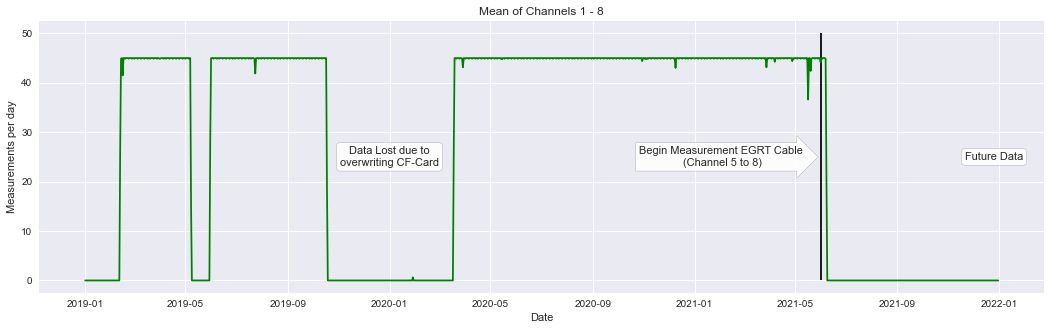

In [16]:
#Plot mean measurements per channel
plt.style.use("seaborn")
plt.figure(figsize=[18,5])
plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of Channels 1 - 8")

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=25; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
plt.text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
plt.text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
ymax=max(np.concatenate([mean_2019,mean_2020,mean_2021])) + 5
plt.vlines(x, ymin=0, ymax=ymax, colors="black",linestyles="-")
bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=120)) 
plt.text(x, y,"Begin Measurement EGRT Cable\n (Channel 5 to 8)", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    save_path = "pictures/mean_of_all_channels_measpday.png"
    save_path_dpi720 = "pictures/dpi720/mean_of_all_channels_measpday_dpi720.png"
    plt.savefig(save_path)
    plt.savefig(save_path_dpi720, dpi=720)
    # copy pictures to my_database
    save_to = path_to_controller[0] + "\..\..\my_database\overview_plots"
    save_to_dpi720 = path_to_controller[0] + "\..\..\my_database\overview_plots\dpi720"
    copy_file(save_path, save_to)
    copy_file(save_path_dpi720, save_to_dpi720)
plt.show()

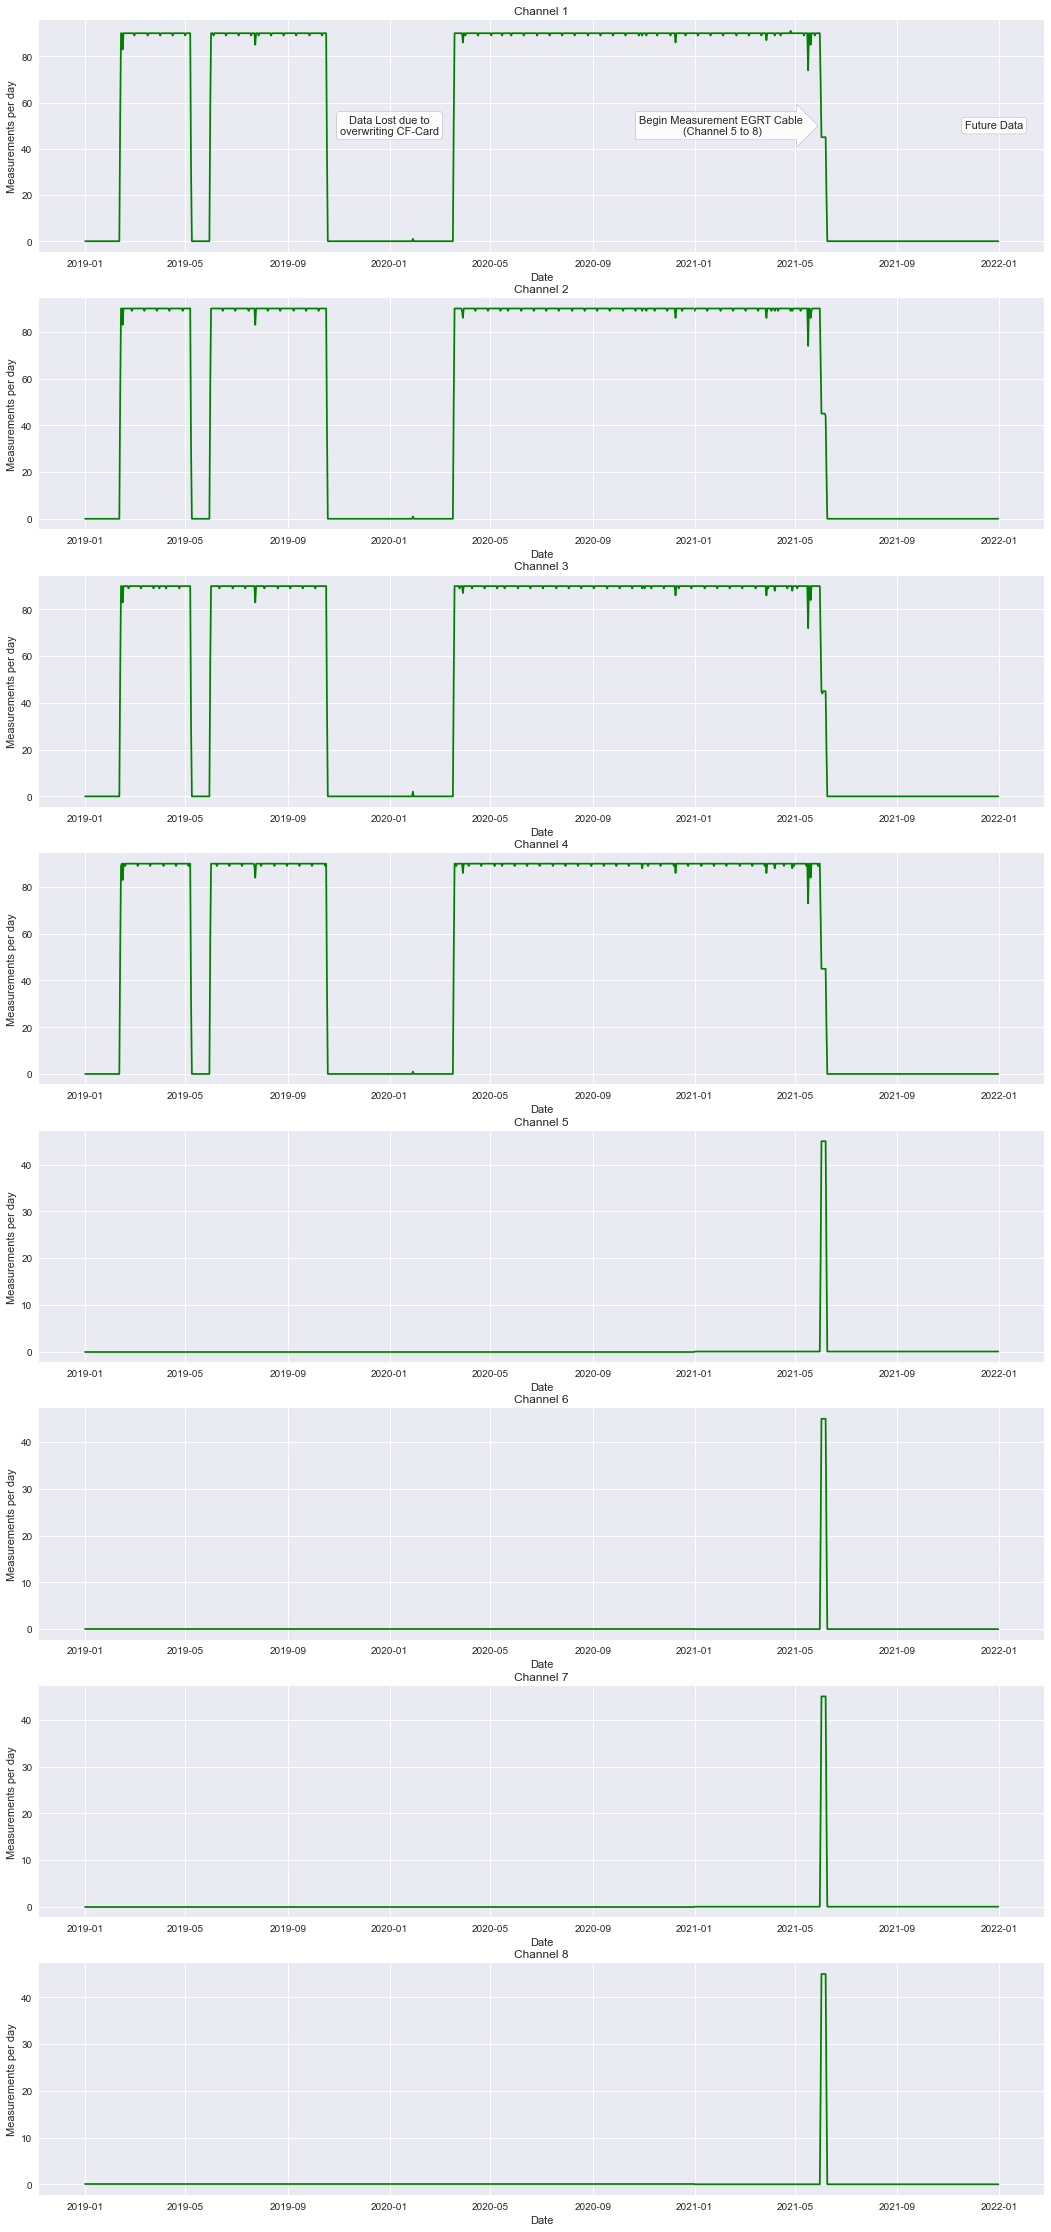

In [17]:
# Plot each channel seperate
#from cycler import cycler

plt.style.use("seaborn")
# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(8,1,figsize=[18,40])
for channel in ["1","2","3","4","5","6","7","8"]:
    n=int(channel)-1
    c="green"
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

# PLOT ACCESSOIREs, Plot Patches with description - copied from mean plot
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
axs[0].text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
axs[0].text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
#x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=120)) 
axs[0].text(x, y,"Begin Measurement EGRT Cable\n (Channel 5 to 8)", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    save_path = "pictures/all_channels_measpday.png"
    save_path_dpi720 = "pictures/dpi720/all_channels_measpday_dpi720.png"
    plt.savefig(save_path)
    plt.savefig(save_path_dpi720, dpi=720)
    # copy pictures to my_database
    save_to = path_to_controller[0] + "\..\..\my_database\overview_plots"
    save_to_dpi720 = path_to_controller[0] + "\..\..\my_database\overview_plots\dpi720"
    copy_file(save_path, save_to)
    copy_file(save_path_dpi720, save_to_dpi720)
plt.show()
# part which was overwritten, 2019-09 till 2020-01, in sciebo are data till 2019-10.

# 90 Messungen pro Tag pro Channel is maximum: 24*60*60/45/8 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 45: Messungen pro Tag
# 8: Channel in denen gemessen wird

In [18]:
# To do
# divide notebook into two
#   one which only imports and saves data
#   another one which analyses (plots) the data
#   atleast create a seperate script for plotting, maybe also keep some plots in the import script


# To-Do
# Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt
#   evntl markante Datenpunkte mithilfe von (rotem) Punkt markieren und label / patch dran machen

In [19]:
last_month=list(data_2021["1"].keys())[-1]
last_measurement_2021 = data_2021["1"][last_month].index[-1]
last_measurement_2021 #last measurement of channel 1

Timestamp('2021-06-08 10:37:21')